<a href="https://colab.research.google.com/github/somesh636/Deep_Fake_Audio_Synthesis/blob/Reference_Paper/ECE657_Proj_Deep_Learning_based_Text_to_speech_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Based Text to Speech conversion


The below models that are trained are [Tacotron](https://github.com/Emotional-Text-to-Speech/tacotron_pytorch) and [DC-TTS](https://github.com/Emotional-Text-to-Speech/pytorch-dc-tts).



## Downloading the necessary libraries
## Installing the dependences
##Gathering the trained data





In [1]:
! git clone https://github.com/Emotional-Text-to-Speech/pytorch-dc-tts
! git clone --recursive https://github.com/Emotional-Text-to-Speech/tacotron_pytorch.git
! cd "tacotron_pytorch/" && pip install -e .
! pip install unidecode
! pip install gdown
! mkdir trained_models

fatal: destination path 'pytorch-dc-tts' already exists and is not an empty directory.
fatal: destination path 'tacotron_pytorch' already exists and is not an empty directory.
Obtaining file:///content/tacotron_pytorch
  Found existing installation: tacotron-pytorch 0.0.1+e6b1a39
    Can't uninstall 'tacotron-pytorch'. No files were found to uninstall.
  Running setup.py develop for tacotron-pytorch
mkdir: cannot create directory ‘trained_models’: File exists


In [2]:


import gdown
url = 'https://drive.google.com/uc?id=1rmhtEl3N3kAfnQM6J0vDGSCCHlHLK6kw'
output = 'trained_models/angry_dctts.pth'
gdown.download(url, output, quiet=False)
url = 'https://drive.google.com/uc?id=1bP0eJ6z4onr2klolzU17Y8SaNspxQjF-'
output = 'trained_models/neutral_dctts.pth'
gdown.download(url, output, quiet=False)
url = 'https://drive.google.com/uc?id=1WWE9zxS3FRgD0Y5yIdNmLY9-t5gnBsNt'
output = 'trained_models/ssrn.pth'
gdown.download(url, output, quiet=False)
url = 'https://drive.google.com/uc?id=1N6Ykrd1IaPiNdos_iv0J6JbY2gBDghod'
output = 'trained_models/disgust_tacotron.pth'
gdown.download(url, output, quiet=False)
url = 'https://drive.google.com/uc?id=15m0PZ8xaBocb_6wDjAU6S4Aunbr3TKkM'
output = 'trained_models/amused_tacotron.pth'
gdown.download(url, output, quiet=False)
url = 'https://drive.google.com/uc?id=1D6HGWYWvhdvLWQt4uOYqdmuVO7ZVLWNa'
output = 'trained_models/sleepiness_tacotron.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1rmhtEl3N3kAfnQM6J0vDGSCCHlHLK6kw
To: /content/trained_models/angry_dctts.pth
288MB [00:01, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bP0eJ6z4onr2klolzU17Y8SaNspxQjF-
To: /content/trained_models/neutral_dctts.pth
95.9MB [00:00, 230MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WWE9zxS3FRgD0Y5yIdNmLY9-t5gnBsNt
To: /content/trained_models/ssrn.pth
331MB [00:01, 243MB/s]
Downloading...
From: https://drive.google.com/uc?id=1N6Ykrd1IaPiNdos_iv0J6JbY2gBDghod
To: /content/trained_models/disgust_tacotron.pth
68.3MB [00:00, 275MB/s]
Downloading...
From: https://drive.google.com/uc?id=15m0PZ8xaBocb_6wDjAU6S4Aunbr3TKkM
To: /content/trained_models/amused_tacotron.pth
68.3MB [00:00, 270MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D6HGWYWvhdvLWQt4uOYqdmuVO7ZVLWNa
To: /content/trained_models/sleepiness_tacotron.pth
68.3MB [00:00, 112MB/s] 


'trained_models/sleepiness_tacotron.pth'

In [3]:
%tensorflow_version 1.x 
%pylab inline
rcParams["figure.figsize"] = (10,5)

import os
import sys
import numpy as np
sys.path.append('pytorch-dc-tts/')
sys.path.append('pytorch-dc-tts/models')
sys.path.append("tacotron_pytorch/")
sys.path.append("tacotron_pytorch/lib/tacotron")

# For the Deep Convolutional network-Text To Speech
import torch
from text2mel import Text2Mel
from ssrn import SSRN
from audio import save_to_wav, spectrogram2wav
from utils import get_last_checkpoint_file_name, load_checkpoint_test, save_to_png, load_checkpoint
from datasets.emovdb import vocab, get_test_data

# For the Tacotron
from text import text_to_sequence, symbols
# from util import audio

from tacotron_pytorch import Tacotron
from synthesis import tts as _tts

# For Audio/Display purposes
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import display
from google.colab import widgets
from google.colab import output
import warnings
warnings.filterwarnings('ignore')


torch.set_grad_enabled(False)
text2mel = Text2Mel(vocab).eval()

ssrn = SSRN().eval()
load_checkpoint('trained_models/ssrn.pth', ssrn, None)

model = Tacotron(n_vocab=len(symbols),
                 embedding_dim=256,
                 mel_dim=80,
                 linear_dim=1025,
                 r=5,
                 padding_idx=None,
                 use_memory_mask=False,
                 )

def visualize(alignment, spectrogram, Emotion):
    label_fontsize = 16
    tb = widgets.TabBar(['Alignment', 'Spectrogram'], location='top')
    with tb.output_to('Alignment'):
      imshow(alignment.T, aspect="auto", origin="lower", interpolation=None)
      xlabel("Decoder timestamp", fontsize=label_fontsize)
      ylabel("Encoder timestamp", fontsize=label_fontsize)
    with tb.output_to('Spectrogram'):
      if Emotion == 'Disgust' or Emotion == 'Amused' or Emotion == 'Sleepiness':
        librosa.display.specshow(spectrogram.T, sr=fs,hop_length=hop_length, x_axis="time", y_axis="linear")
      else:
        librosa.display.specshow(spectrogram, sr=fs,hop_length=hop_length, x_axis="time", y_axis="linear")

      xlabel("Time", fontsize=label_fontsize)
      ylabel("Hz", fontsize=label_fontsize)

def tts_dctts(text2mel, ssrn, text):
  sentences = [text]

  max_N = len(text)
  L = torch.from_numpy(get_test_data(sentences, max_N))
  zeros = torch.from_numpy(np.zeros((1, 80, 1), np.float32))
  Y = zeros
  A = None

  for t in range(210):
      _, Y_t, A = text2mel(L, Y, monotonic_attention=True)
      Y = torch.cat((zeros, Y_t), -1)
      _, attention = torch.max(A[0, :, -1], 0)
      attention = attention.item()
      if L[0, attention] == vocab.index('E'):  # EOS
          break

  _, Z = ssrn(Y)
  Y = Y.cpu().detach().numpy()
  A = A.cpu().detach().numpy()
  Z = Z.cpu().detach().numpy()

  return spectrogram2wav(Z[0, :, :].T), A[0, :, :], Y[0, :, :]


def tts_tacotron(model, text):
    waveform, alignment, spectrogram = _tts(model, text)
    return waveform, alignment, spectrogram 

def present(waveform, Emotion, figures=False):
  if figures!=False:
        visualize(figures[0], figures[1], Emotion)
  IPython.display.display(Audio(waveform, rate=fs))

  
fs = 20000 #20000
hop_length = 250
model.decoder.max_decoder_steps = 200

TensorFlow 1.x selected.
Populating the interactive namespace from numpy and matplotlib
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

trained_models/ssrn.pth
loaded checkpoint epoch=0 step=0


## Demo waveform and speech generation

- Select an ```Emotion``` from the dropdown and enter the ```Text``` that you want to be generated. 

**Play the speech with the generated audio player and view the required plots by clicking on their respective tabs!**




Populating the interactive namespace from numpy and matplotlib
Warning! doesn't seems to be converged


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

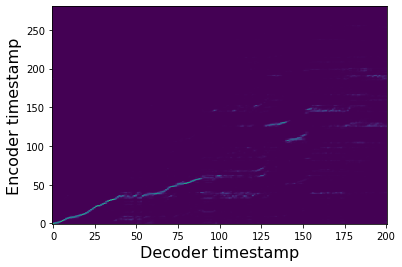

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

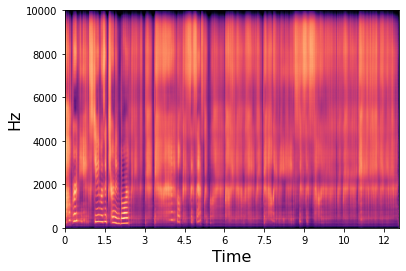

<IPython.core.display.Javascript object>

In [4]:
#@title Select the emotion and type the text

%pylab inline

Emotion = "Amused" #@param ["Neutral", "Angry", "Disgust", "Sleepiness", "Amused"]
Text = 'Albert Einstein was a German-born theoretical physicist, widely acknowledged to be one of the greatest physicists of all time. Einstein is known for developing the theory of relativity, but he also made important contributions to the development of the theory of quantum mechanics' #@param {type:"string"}

wav, align, mel = None, None, None

if Emotion == "Neutral":
  load_checkpoint('trained_models/'+Emotion.lower()+'_dctts.pth', text2mel, None)
  wav, align, mel = tts_dctts(text2mel, ssrn, Text)
elif Emotion == "Angry":
  load_checkpoint_test('trained_models/'+Emotion.lower()+'_dctts.pth', text2mel, None)
  wav, align, mel = tts_dctts(text2mel, ssrn, Text)
  # wav = wav.T
elif Emotion == "Disgust" or Emotion == "Amused" or Emotion == "Sleepiness":
  checkpoint = torch.load('trained_models/'+Emotion.lower()+'_tacotron.pth', map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint["state_dict"])
  wav, align, mel = tts_tacotron(model, Text)

present(wav, Emotion, (align,mel))

